# Imports

In [27]:
import pandas as pd
import pymc3 as pm
import numpy as np
import os
import sys
import json
import theano.tensor as tt
import arviz as az
sys.path.insert(0, os.path.abspath('../python'))

# Load data

## Empirical data

In [2]:
datadir = "../experiments/experiment3/data/cleaned_data.json"
data = pd.read_json(datadir)

In [3]:
data.head()

,trial_index,subject_id,exp_condition,rt,response_,task,correct_response,correct,task_condition,scene,...,zlogrt,trial_condition,response,participant_accuracy,trial_accuracy,scene_accuracy,sim_time,collision,straight_path,3
0,0,61716480d6da1714ff60ed0d,j,884,f,response,f,True,No,low_nocol_yessp_1,...,-0.681529,No,No,0.895833,0.765957,0.936170,low,nocol,yessp,1.mp4
1,1,61716480d6da1714ff60ed0d,j,726,f,response,j,False,Yes,low_yescol_yessp_2,...,-1.182728,Yes,No,0.895833,0.702128,0.872340,low,yescol,yessp,2.mp4
2,2,61716480d6da1714ff60ed0d,j,885,f,response,f,True,No,low_nocol_nosp_2,...,-0.678651,No,No,0.895833,0.914894,0.893617,low,nocol,nosp,2.mp4
3,3,61716480d6da1714ff60ed0d,j,981,f,response,f,True,No,med_nocol_nosp_3,...,-0.416518,No,No,0.895833,0.787234,0.914894,med,nocol,nosp,3.mp4
4,4,61716480d6da1714ff60ed0d,j,1189,j,response,j,True,Yes,high_yescol_yessp_2,...,0.072943,Yes,Yes,0.895833,0.893617,1.000000,high,yescol,yessp,2.mp4


## Scene arguments

In [4]:
scenedir = "../data/json/pilot3/"
scene_files = [scene_json for scene_json in os.listdir(scenedir) if scene_json.endswith('.json')]

In [5]:
# Used in my_model
scene_args = {}
for file in scene_files:
    with open(scenedir+file, 'r') as f:
        sargs = (json.loads(f.read()))
        scene_args[sargs['name'].split(".")[0]] = sargs

# Model

In [11]:
from models import abstraction_simulation_pp

def my_model(theta,x):
    '''
    :param theta: Expected theta == [N, D, E]
    :param x: Expected list of scene arguments
    '''
    # Unpack model params
    N,D,E = theta
    # Model predictions
    y_pred = []
    # Get model predictins for each scene
    for scene in x:
        y_pred.append(abstraction_simulation_pp(scene_args[scene],int(N),D,E))
    # Convert to array
    y_pred = np.array(y_pred)
    return y_pred

In [7]:
# The loglikelihood function
def log_likelihood(theta, x, data, sigma):
    '''
    Normal log-likelihoood
    
    :param data: Empirical repsonse times
    :param sigma: Empirical response time stddev
    :param x: Scene arguments, expected: [scene_1,scene2,...]
    :param theta: Model parameters, expected: [N,D,E]
    '''
    
    # Model simulation times
    y_pred = my_model(theta,x)
    
    # Divergence from data
    retval = -(0.5 / sigma ** 2) * np.sum((data - y_pred) ** 2)
    return retval

In [8]:
# define a theano Op for our likelihood function
class LogLike(tt.Op):
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl)  # output the log-likelihood

In [9]:
# Observed RT
RT_y_mean = data.groupby('scene').rt.apply(np.mean)
RT_y_std = data.groupby('scene').rt.apply(np.std).mean()
RT_x = RT_y_mean.index.to_list()

In [12]:
abstraction_model = pm.Model()
loglike = LogLike(log_likelihood,RT_y_mean,RT_x,RT_y_std)

with abstraction_model:
    # Priors on model parameters
    # Number of samples to take from simulator
    N = pm.DiscreteUniform("N",lower=1,upper=25)
    # Length of path projection
    D = pm.TruncatedNormal("D",sigma=10, lower=20)
    # Cosine similarity threshold
    E = pm.TruncatedNormal("E",sigma=0.1,lower=0,upper=1)
    
    theta = tt.as_tensor_variable([N,D,E])
    
    pm.Potential("likelihood",loglike(theta))
    

In [24]:
ndraws = 1000  # number of draws from the distribution
nburn = 1000  # number of "burn-in points" (which we'll discard)

In [25]:
with abstraction_model:
    trace = pm.sample(ndraws,chains=1, cores=1, tune=nburn, discard_tuned_samples=True, step=pm.Metropolis())
    print(pm.summary(trace).to_string())

/var/folders/6l/1kj5v3gx7r3264z3jy47_43c0000gn/T/ipykernel_2952/1716333079.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(ndraws,chains=1, cores=1, tune=nburn, discard_tuned_samples=True, step=pm.Metropolis())
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [E]
INFO:pymc3:>Metropolis: [E]
>Metropolis: [D]
INFO:pymc3:>Metropolis: [D]
>Metropolis: [N]
INFO:pymc3:>Metropolis: [N]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 6084 seconds.
INFO:pymc3:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 6084 seconds.
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (1000) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc3:Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
N  24.894  0.339  24.000   25.000      0.030    0.021     128.0     132.0    NaN
D  20.280  0.267  20.001   20.752      0.018    0.012     205.0     297.0    NaN
E   0.078  0.063   0.000    0.197      0.004    0.003     148.0      91.0    NaN


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (1000) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


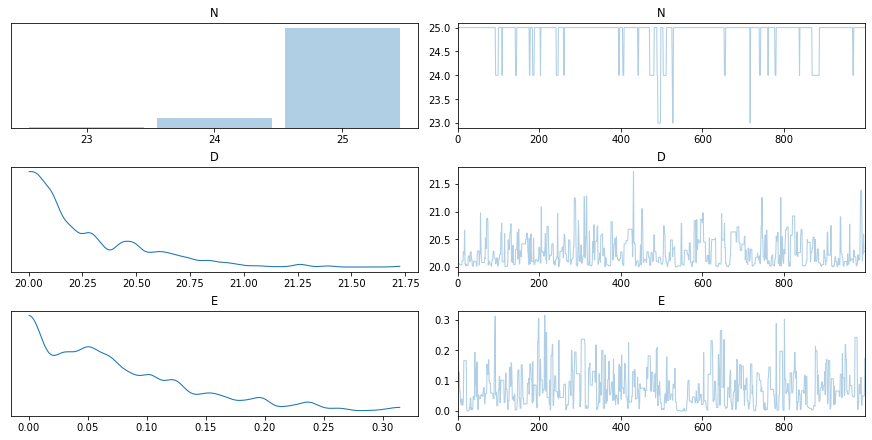

In [28]:
with abstraction_model:
    az.plot_trace(trace);

In [29]:
map_estimate = pm.find_MAP(model=abstraction_model)

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
